# ARMA Task

In this part, we are supposed to do finish these tasks:
1. Preprocess data
2. Familar with data and define the kinds of sensor
3. Learn an autoregressive moving average model for each individual sensor
4. Use autocorrelation plots in order to identify the order of the ARMA models
5. Apply model selection methods to determine parameters

Step1: Preprocessing

In [402]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from matplotlib.pylab import rcParams
from pandas.core import datetools
rcParams['figure.figsize'] = 15, 7
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import  stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.api import qqplot

In [371]:
##################################################
#               LOAD DATA                        #
##################################################
train03 = pd.read_csv('BATADAL_dataset03.csv')
train04 = pd.read_csv('BATADAL_dataset04.csv')
test_set = pd.read_csv('BATADAL_test_dataset.csv')
# shape of these three dataset
# (8761, 45)# (4177, 45)# (2089, 44)
# row = 10
# print(train03.shape, train03.iloc[row],'\n',train04.shape, train04.iloc[row], test_set.shape, test_set.iloc[row])
# print(train03.head())
# print(type(train04['DATETIME']))

<class 'pandas.core.series.Series'>


In [252]:
print(list(series))

['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']


Let's preprocess our data a little bit before moving forward. Hourly data can be tricky to work with since it’s a briefer amount of time, so let's use daily averages instead. We’ll make the conversion with the resample function. For simplicity, we can also use the fillna() function to ensure that we have no missing values in our time series. And we apply timestamp as index.

In [343]:
L_group = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']
FS_1_6_group = ['F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6']
FS_7_12_group = [ 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2']
P_group = ['P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

In [362]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H')

train04_series = pd.read_csv('BATADAL_dataset04.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
# print(train04_series.shape)#(4177, 44)
train04_series = train04_series.resample('D').mean()
# print(train04_series.shape)#(175, 44)
train04_series = train04_series.fillna(train04_series.bfill())
# print(train04_series.shape)#(175, 44)

train03_series = pd.read_csv('BATADAL_dataset03.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
# print(train03_series.shape)# (8761, 44)
train03_series = train03_series.resample('D').mean()
# print(train03_series.shape)# (366, 44)

print(train04_series.index)
print(train03_series.index)

DatetimeIndex(['2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07',
               '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11',
               '2016-07-12', '2016-07-13',
               ...
               '2016-12-16', '2016-12-17', '2016-12-18', '2016-12-19',
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-24', '2016-12-25'],
              dtype='datetime64[ns]', name='DATETIME', length=175, freq='D')
DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11', '2014-01-12', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31',
               '2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06'],
              dtype='datetime64[ns]', name='DATETIME', length=366, freq='D')


Step2. Familar with data and define the kinds of sensor. L_group = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7'] is our sensor group including 7 different sensors.

In [376]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]
def best_diff(df, maxdiff = 10):
    p_set = {}
    for i in range(0, maxdiff):
        temp = df.copy() #每次循环前，重置
        if i == 0:
            temp['diff'] = temp[temp.columns[1]]
        else:
            temp['diff'] = temp[temp.columns[1]].diff(i)
            temp = temp.drop(temp.iloc[:i].index) #差分后，前几行的数据会变成nan，所以删掉
        pvalue = test_stationarity(temp['diff'])
        p_set[i] = pvalue
        p_df = pd.DataFrame.from_dict(p_set, orient="index")
        p_df.columns = ['p_value']
    i = 0
    while i < len(p_df):
        if p_df['p_value'][i]<0.01:
            bestdiff = i
            break
        i += 1
    return bestdiff

In [384]:
# plt.plot(train04_series[L_group])
# plt.show()
# plt.plot(train03_series[L_group])
# plt.show()
print(test_stationarity(train04_series['L_T1']))
print(test_stationarity(train03_series['L_T1']))
# autocorrelation_plot(train04_series['L_T1'])
# plt.show()
# autocorrelation_plot(train03_series['L_T1'])
# plt.show()
train04_diff = best_diff(train04_series, maxdiff = 10)
train03_diff = best_diff(train03_series, maxdiff = 10)
print(train04_diff,train03_diff)


1.5133392978843544e-18
1.0061207919984195e-13
0 0
Best ARIMANone MSE=inf


In [349]:
# series.describe()

Step3. Learn an autoregressive moving average model for each individual sensor


In [ ]:
# 1.获取被观测系统时间序列数据；
# 2.对数据绘图，观测是否为平稳时间序列；对于非平稳时间序列要先进行d阶差分运算，化为平稳时间序列；
# 3.经过第二步处理，已经得到平稳时间序列。要对平稳时间序列分别求得其自相关系数ACF 和偏自相关系数PACF ，通过对自相关图和偏自相关图的分析，得到最佳的阶层 p 和阶数 q
# 4.由以上得到的d、q、p ，得到ARIMA模型。然后开始对得到的模型进行模型检验。

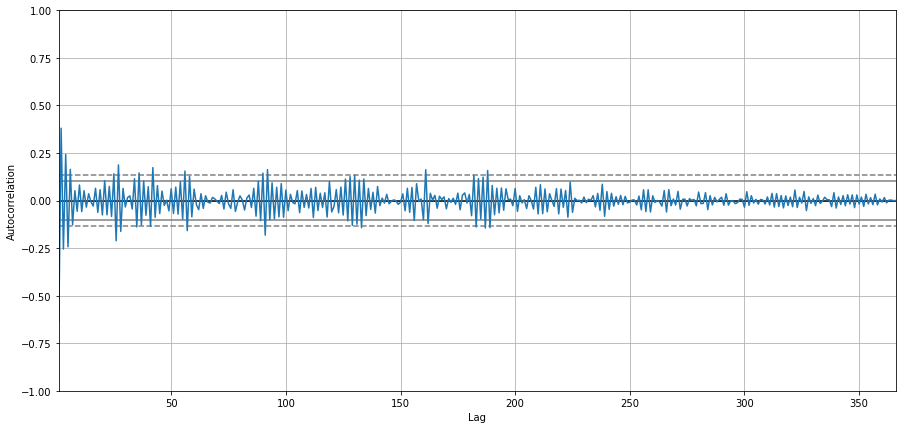

1.0061207919984195e-13


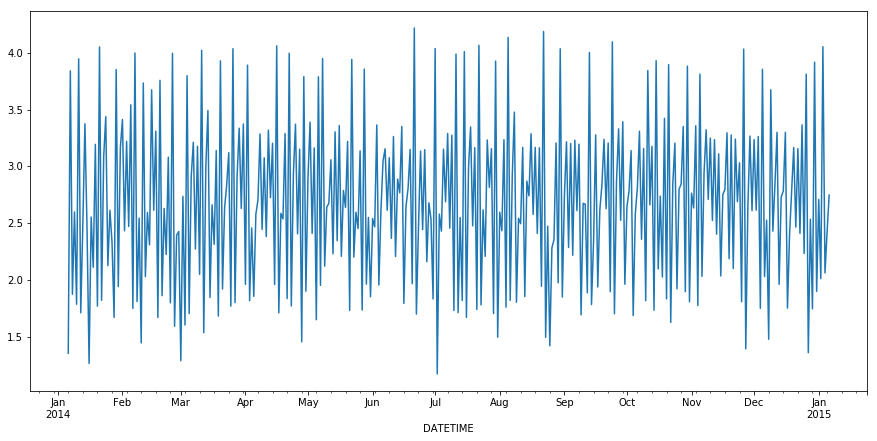

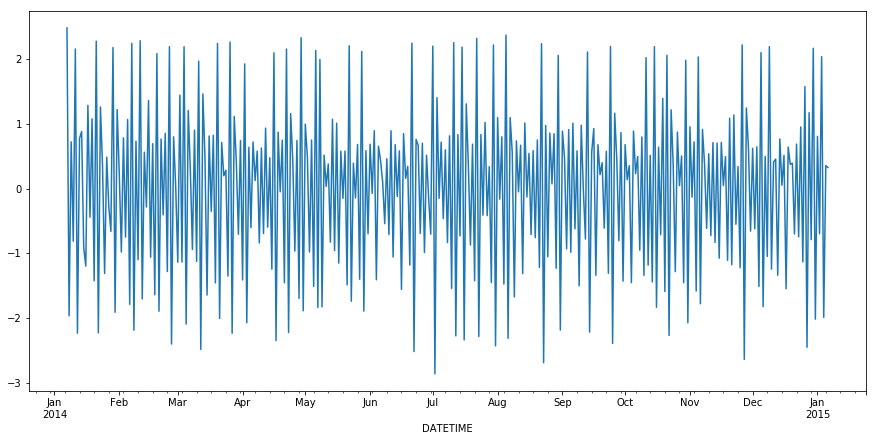

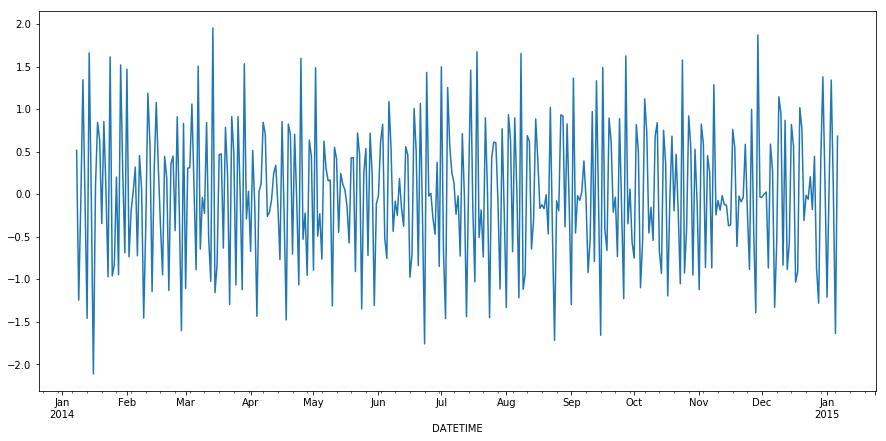

In [387]:
# find optimal diff
autocorrelation_plot(train03_series['L_T1'])
plt.show()
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]
stationarity = test_stationarity(train03_series['L_T1'])
print(stationarity)
train03_series['L_T1'].plot()
plt.show()
diff1 = train03_series['L_T1'].diff(1)
diff1.plot()
plt.show()
diff2 = train03_series['L_T1'].diff(2)
diff2.plot()
plt.show()


In [ ]:
#reconstruct data


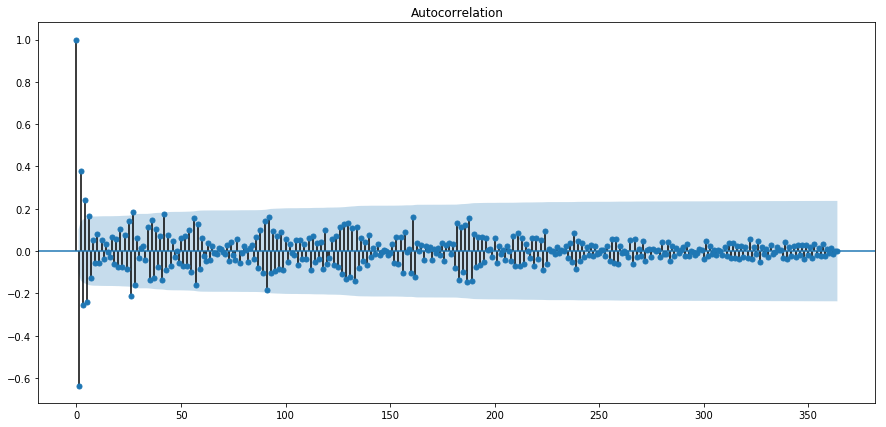

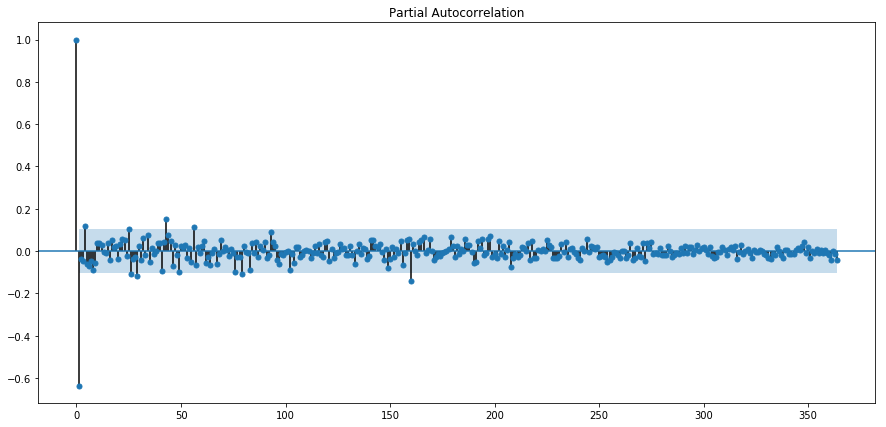

In [396]:
dta= train03_series['L_T1']
fig = plt.figure(figsize=(12,5))
fig = sm.graphics.tsa.plot_acf(dta,lags=364)
plt.show()
fig = sm.graphics.tsa.plot_pacf(dta,lags=364)
plt.show()

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [399]:
arma_mod1 = sm.tsa.ARMA(dta,(7,2)).fit()
print(arma_mod1.aic,arma_mod1.bic,arma_mod1.hqic)
arma_mod2 = sm.tsa.ARMA(dta,(0,2)).fit()
print(arma_mod2.aic,arma_mod2.bic,arma_mod2.hqic)
arma_mod3 = sm.tsa.ARMA(dta,(7,0)).fit()
print(arma_mod3.aic,arma_mod3.bic,arma_mod3.hqic)

607.1171554622626 650.0461221296777 624.175924200972
623.4316177294593 639.0421510630647 629.6348063617172
612.7417562995265 647.8654563001388 626.6989307221069


1.9787138941682068


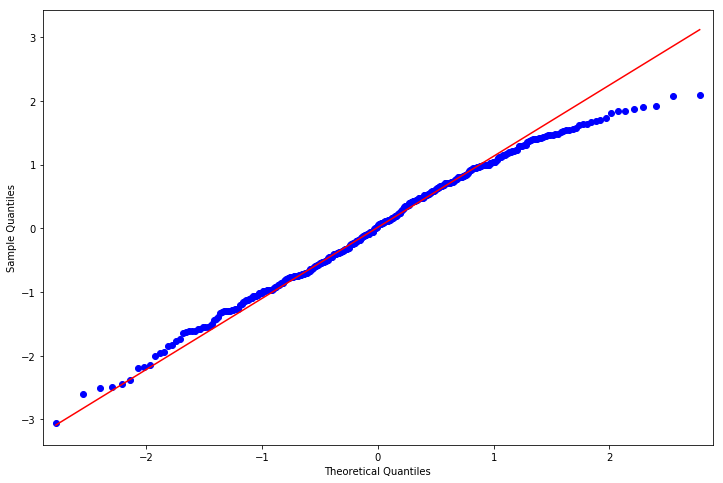

In [403]:
print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid = arma_mod1.resid#残差
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

2014-12-28    3.418156
2014-12-29    2.093201
2014-12-30    2.949302
2014-12-31    2.233258
2015-01-01    2.941184
2015-01-02    2.366646
2015-01-03    2.849914
2015-01-04    2.525242
2015-01-05    2.826878
2015-01-06    2.611599
Freq: D, dtype: float64


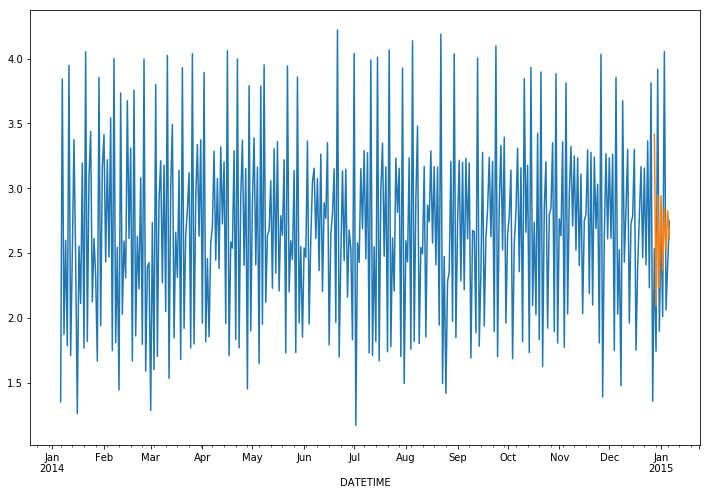

In [407]:
predict_sunspots = arma_mod1.predict('2014-12-28', '2015-01-06', dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.ix['2014-01-06':].plot(ax=ax)
predict_sunspots.plot(ax=ax)